In [37]:
import rioxarray as rioxr
import geopandas as gpd
import matplotlib.pyplot as plt
import geoutils as gu
from oggm import cfg, utils, workflow, tasks, graphics
import glacier_lengths
import xdem
import rasterio
import matplotlib.patches as mpatches  

In [38]:
# Load the glaciers' outlines, add year
glaciername= "Fountain2023"


old_outline = gpd.read_file(r"D:\BICdata\Fountain1985.shp")
new_outline = gpd.read_file(r"D:\BICdata\Fountain2023.shp")

#old_outline = gpd.read_file(r"D:\All_outline\Rundle1959_Project.shp")
#new_outline = gpd.read_file(r"D:\All_outline\Rundle2023.shp")

# Load your inventory
#inventory = old_outline
inventory = new_outline

# Load the dem data
dem = rioxr.open_rasterio(r"D:\SNPArcticDEM.tif")


In [39]:
# Use utils.cook_rgidf to make it OGGM-ready, set o1_region to '00'
gdf = utils.cook_rgidf(inventory,"00")

gdf.head()

,RGIId,CenLon,CenLat,GLIMSId,BgnDate,EndDate,O1Region,O2Region,Area,Zmin,...,Lmax,Status,Connect,Form,TermType,Surging,Linkages,check_geom,Name,geometry
0,RGI60-00.00001,-78.474686,73.011718,,20009999,9999999,00,01,-9999.0,-9999.0,...,-9999,0,0,0,0,0,1,None,,"MULTIPOLYGON Z (((-78.34181 73.04385 0.00000, ..."


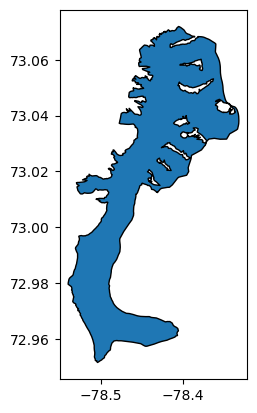

In [40]:
gdf.plot(edgecolor='k');

In [41]:
cfg.initialize(logging_level='WARNING')

# Parameters
cfg.PARAMS['use_multiprocessing'] = True  # this is often a good idea
cfg.PARAMS['use_rgi_area'] = False  # this is required for user-defined inventories
cfg.PARAMS['use_intersects'] = False  # we don't care about intersects for centerlines
cfg.PARAMS['border'] = 10  # no need to make a large map

# Optional: change the grid resolution
# E.g. fixed grid spacing
# cfg.PARAMS['grid_dx_method'] = 'fixed'
# cfg.PARAMS['fixed_dx'] = 10
# Or variable but twice higher than default 
cfg.PARAMS['grid_dx_method'] = 'square'
cfg.PARAMS['d1'] = 7  # (default is 14)
cfg.PARAMS['d2'] = 5  # (default is 10)
cfg.PARAMS['dmax'] = 200  # (default is 100)

# Tell OGGM to use our user DEM (important!)
cfg.PATHS['dem_file'] = r"D:\SNPArcticDEM.tif"

# Where to work
cfg.PATHS['working_dir'] = utils.gettempdir(dirname=f'{glaciername}_CENTERLINES', reset=True)
cfg.PATHS['working_dir']

2024-11-24 15:39:09: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2024-11-24 15:39:09: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2024-11-24 15:39:09: oggm.cfg: Multiprocessing: using all available processors (N=16)
2024-11-24 15:39:09: oggm.cfg: Multiprocessing switched ON after user settings.
2024-11-24 15:39:09: oggm.cfg: PARAMS['use_rgi_area'] changed from `True` to `False`.
2024-11-24 15:39:09: oggm.cfg: PARAMS['use_intersects'] changed from `True` to `False`.
2024-11-24 15:39:09: oggm.cfg: PARAMS['border'] changed from `80` to `10`.
2024-11-24 15:39:09: oggm.cfg: PARAMS['d1'] changed from `14.0` to `7`.
2024-11-24 15:39:09: oggm.cfg: PARAMS['d2'] changed from `10.0` to `5`.


'C:\\Users\\WilsonSIRL5-MCY-E113\\AppData\\Local\\Temp\\OGGM\\Fountain2023_CENTERLINES'

In [42]:
gdirs = workflow.init_glacier_directories(gdf)

2024-11-24 15:39:09: oggm.workflow: Execute entity tasks [GlacierDirectory] on 1 glaciers


In [43]:
workflow.execute_entity_task(tasks.define_glacier_region, gdirs)  # Use the user DEM
workflow.execute_entity_task(tasks.glacier_masks, gdirs)
workflow.execute_entity_task(tasks.compute_centerlines, gdirs)

2024-11-24 15:39:09: oggm.workflow: Execute entity tasks [define_glacier_region] on 1 glaciers
2024-11-24 15:39:12: oggm.workflow: Execute entity tasks [glacier_masks] on 1 glaciers
2024-11-24 15:39:12: oggm.workflow: Execute entity tasks [compute_centerlines] on 1 glaciers


[None]

In [44]:
from oggm.utils import write_centerlines_to_shape, mkdir

# We want to write in here
mkdir('outputs')

write_centerlines_to_shape(gdirs,  # The glaciers to process
                           path=f'D:\\outputs\\{glaciername}_Centerlines.shp',  # The output file
                           to_tar=False,  # set to True to put everything into one single tar file
                           to_crs=inventory.crs,  # Write into the projection of the original inventory
                           keep_main_only=True,  # Write only the main flowline and discard the tributaries
                           )

2024-11-24 15:39:12: oggm.utils: Applying global task write_centerlines_to_shape on 1 glaciers
2024-11-24 15:39:12: oggm.utils: write_centerlines_to_shape on D:\outputs\Fountain2023_Centerlines.shp ...
2024-11-24 15:39:12: oggm.workflow: Execute entity tasks [get_centerline_lonlat] on 1 glaciers


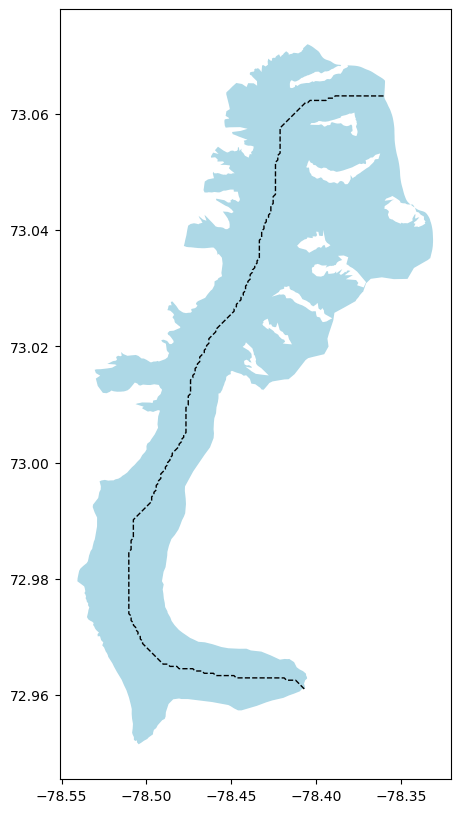

In [45]:
# Assuming gdf (shapefile) is already defined
# read centerline shape file
cls = gpd.read_file(f'outputs\\{glaciername}_Centerlines.shp')

# Ensure CRS is same for both
cls = cls.to_crs(gdf.crs)

fig, ax = plt.subplots(figsize=(10, 10))

# Plot the shapefile
gdf.plot(ax=ax, facecolor='lightblue')

# Plot the centerline on top, with a custom design (you can adapt it)
cls.plot(ax=ax, color='black', linewidth=1, linestyle='--')
plt.show()

In [46]:
write_centerlines_to_shape(gdirs,  # The glaciers to process
                           path=f'outputs\\{glaciername}_Centerlines_smooth.shp',  # The output file
                           to_tar=False,  # set to True to put everything into one single tar file
                           to_crs=inventory.crs,  # Write into the projection of the original inventory
                           keep_main_only=True,  # Write only the main flowline and discard the tributaries
                           ensure_exterior_match=True,  # NEW! Ensure that the lines are touching the outlines
                           simplify_line_before=0.75,  # NEW! this option reduces the number of vertices along the line
                           corner_cutting=3,  # NEW! this then augments the number of vertices again
                          )

2024-11-24 15:39:12: oggm.utils: Applying global task write_centerlines_to_shape on 1 glaciers
2024-11-24 15:39:12: oggm.utils: write_centerlines_to_shape on outputs\Fountain2023_Centerlines_smooth.shp ...
2024-11-24 15:39:12: oggm.workflow: Execute entity tasks [get_centerline_lonlat] on 1 glaciers


Length of cls: 0.3199330242165429
Length of cls_smooth: 0.2977377600995893


C:\Users\WilsonSIRL5-MCY-E113\AppData\Local\Temp\ipykernel_22540\940457964.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  cls_length = cls.geometry.length.sum()
C:\Users\WilsonSIRL5-MCY-E113\AppData\Local\Temp\ipykernel_22540\940457964.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  cls_smooth_length = cls_smooth.geometry.length.sum()


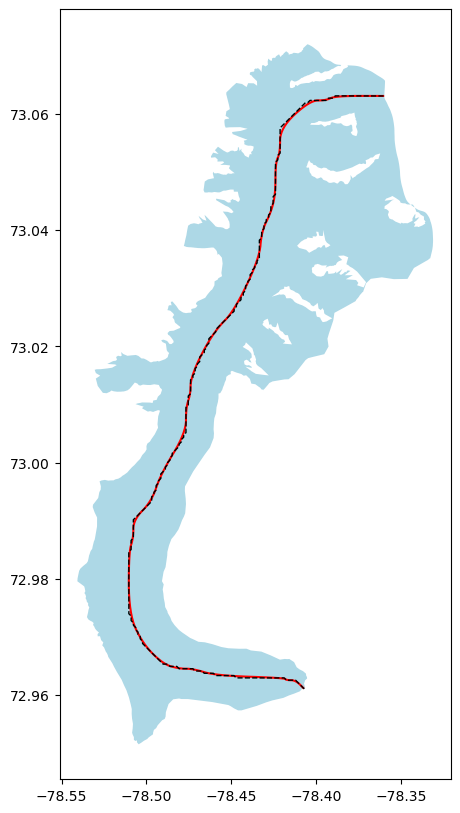

In [47]:
cls_smooth = gpd.read_file(f'outputs\\{glaciername}_Centerlines_smooth.shp')

# Ensure CRS is same for both
cls = cls.to_crs(gdf.crs)
cls_smooth = cls_smooth.to_crs(gdf.crs)  

# Calculate lengths
cls_length = cls.geometry.length.sum()
cls_smooth_length = cls_smooth.geometry.length.sum()

print(f"Length of cls: {cls_length}")
print(f"Length of cls_smooth: {cls_smooth_length}")

fig, ax = plt.subplots(figsize=(10, 10))

# Plot the shapefile
gdf.plot(ax=ax, facecolor='lightblue')

# Plot the centerline on top, with a custom design (you can adapt it)
cls_smooth.plot(ax=ax, color='red')
cls.plot(ax=ax, color='black', linewidth=1, linestyle='--')

plt.show()

In [48]:
# Assuming the CRS has been adjusted as in the previous code snippet...

# Calculate lengths (in kilometers)
cls_length_km = cls.geometry.length.sum() / 1000
cls_smooth_length_km = cls_smooth.geometry.length.sum() / 1000

print(f"Length of cls: {cls_length_km} kilometers")
print(f"Length of cls_smooth: {cls_smooth_length_km} kilometers")


# Calculate the area extent in square kilometers
old_area = old_outline['geometry'].to_crs({'init': 'epsg:32620'}).map(lambda p: p.area / 10**6).sum()
new_area = new_outline['geometry'].to_crs({'init': 'epsg:32620'}).map(lambda p: p.area / 10**6).sum()

print(f"Old outline area extent: {old_area} km²")
print(f"New outline area extent: {new_area} km²")

Length of cls: 0.0003199330242165429 kilometers
Length of cls_smooth: 0.0002977377600995893 kilometers
Old outline area extent: 35.984038546121106 km²
New outline area extent: 30.875704138343714 km²


C:\Users\WilsonSIRL5-MCY-E113\AppData\Local\Temp\ipykernel_22540\1158616646.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  cls_length_km = cls.geometry.length.sum() / 1000
C:\Users\WilsonSIRL5-MCY-E113\AppData\Local\Temp\ipykernel_22540\1158616646.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  cls_smooth_length_km = cls_smooth.geometry.length.sum() / 1000
c:\Users\WilsonSIRL5-MCY-E113\miniconda3\envs\oggm_env\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-

c:\Users\WilsonSIRL5-MCY-E113\miniconda3\envs\oggm_env\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


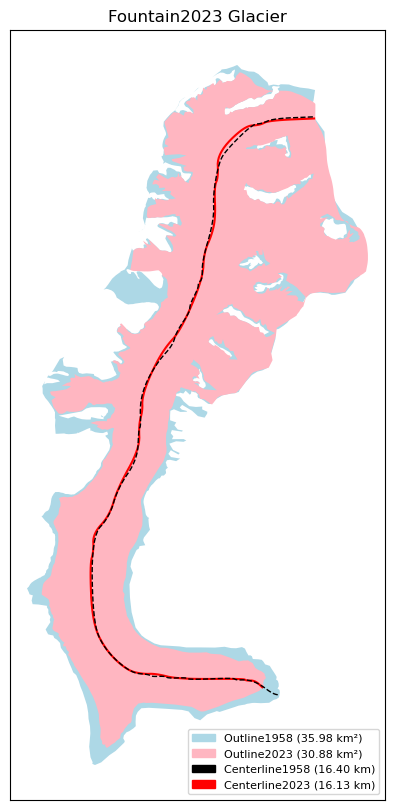

In [49]:
# Read the shapefiles
new_cls_smooth = gpd.read_file(r"D:\outputs\Fountain2023_Centerlines_smooth.shp")
old_cls_smooth = gpd.read_file(r"D:\outputs\Fountain1958_Centerlines_smooth.shp")

# Calculate the area extent
old_area = old_outline.to_crs({'init': 'epsg:32620'}).area.sum() / 10**6
new_area = new_outline.to_crs({'init': 'epsg:32620'}).area.sum() / 10**6

# Calculate the length of the centerlines in km
new_cls_length = new_cls_smooth.geometry.length.sum() / 1000
old_cls_length = old_cls_smooth.geometry.length.sum() / 1000

# Create the plot
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the old outline in light blue
old_outline.plot(ax=ax, facecolor='lightblue')

# Plot the new outline in red
new_outline.plot(ax=ax, facecolor='lightpink')

# Plot the centerlines
new_cls_smooth.plot(ax=ax, color='red')
old_cls_smooth.plot(ax=ax, color='black', linewidth=1, linestyle='--')

# Create legend handles manually
handles = [
    mpatches.Patch(color='lightblue', label=f'Outline1958 ({old_area:.2f} km²)'),
    mpatches.Patch(color='lightpink', label=f'Outline2023 ({new_area:.2f} km²)'),
    mpatches.Patch(color='black', label=f'Centerline1958 ({old_cls_length:.2f} km)'),
    mpatches.Patch(color='red', label=f'Centerline2023 ({new_cls_length:.2f} km)')
]


plt.title(f'{glaciername} Glacier')
# Hide the ticks and labels on both axes
plt.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)

# Add a legend at the bottom left
plt.legend(handles=handles, loc='lower right', prop={'size': 8})

# Show the plot
plt.show()


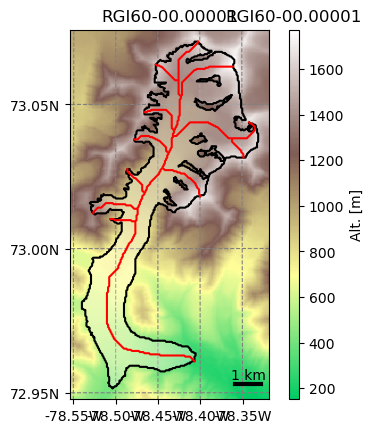

In [50]:
def plot_centerlines(gdir):
    # Read the glacier raster
    from oggm import graphics
    f, ax = plt.subplots()
    df = graphics.plot_domain(gdir, ax=ax)
    
    # Overplot the centerlines
    # Read the centerlines
    cls = gdir.read_pickle('centerlines')
    for cl in cls:
        x, y = cl.line.xy
        ax.plot(x, y, color='r')
    plt.title(gdir.rgi_id)
    plt.show()

# To plot centerline on a single glacier:
plot_centerlines(gdirs[0]) # replace 0 with the index of your glacier
